In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/torontohousingprices/dataset_final.csv
/kaggle/input/folder/README.md
/kaggle/input/folder/sampleOutput.png
/kaggle/input/folder/heatmap.ipynb
/kaggle/input/folder/forAnalysis/data.csv
/kaggle/input/folder/forAnalysis/Neighbourhoods/Neighbourhoods.prj
/kaggle/input/folder/forAnalysis/Neighbourhoods/Neighbourhoods.dbf
/kaggle/input/folder/forAnalysis/Neighbourhoods/Neighbourhoods_fields.csv
/kaggle/input/folder/forAnalysis/Neighbourhoods/Neighbourhoods.shx
/kaggle/input/folder/forAnalysis/Neighbourhoods/Neighbourhoods.cpg
/kaggle/input/folder/forAnalysis/Neighbourhoods/Neighbourhoods.shp


In [2]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
#Get the data
df_train = pd.read_csv('../input/torontohousingprices/dataset_final.csv')
df_train.columns

Index(['Sold_price', 'Squarefootage', 'Type', 'Style', 'Community',
       'Municipality District', 'longitude', 'latitude', 'Bedrooms', 'Dens',
       'Bathrooms', 'Kitchens', 'Rooms', 'Parking Total'],
      dtype='object')

### Analyze 'Sold_price' 

In [4]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

#Descriptive statistics summary
df_train.describe()


,Sold_price,Squarefootage,longitude,latitude,Bedrooms,Dens,Bathrooms,Kitchens,Rooms,Parking Total
count,6208,6208,6090,6090,6208,6208,6208,6208,6208,6208
mean,919592,1141,-79,44,2,0,2,1,6,1
std,669006,783,0,0,1,1,1,0,2,1
min,205000,250,-80,44,0,0,0,0,0,0
25%,581000,650,-79,44,1,0,1,1,4,1
50%,702000,850,-79,44,2,0,2,1,5,1
75%,960000,1300,-79,44,3,1,2,1,6,1
max,10200000,5000,-79,44,8,7,12,5,19,15


<AxesSubplot:xlabel='Sold_price', ylabel='Density'>

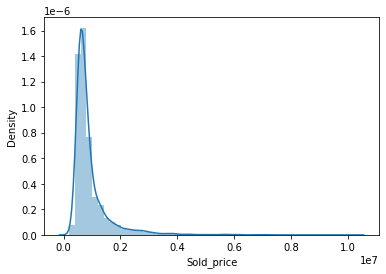

In [5]:
#Sold Price histogram
sns.distplot(df_train['Sold_price'])

### 'Sold_price' Relationship with Numerical Variables

<AxesSubplot:xlabel='Squarefootage', ylabel='Sold_price'>

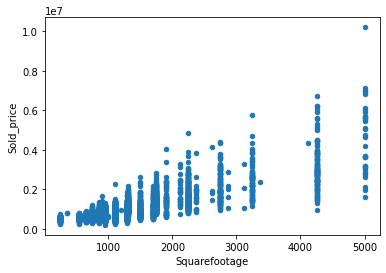

In [6]:
#Scatter plot 'Squarefootage'/'Sold_price'
var = 'Squarefootage'
data = pd.concat([df_train['Sold_price'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Sold_price')

### 'Sold_price' Relationship with Location Variables

In [7]:
print('There are', df_train['Community'].nunique(), 'communities in',
       df_train['Municipality District'].nunique(), 'districts.')

There are 143 communities in 35 districts.


In [8]:
# Get average 'Sold_price' across communities (neighbourhoods)
communities = df_train[['Sold_price','Community']].groupby(['Community'])

community_prices = pd.concat([communities.mean(), communities.count()], axis=1)
community_prices.columns = ['Avg. Price', 'Count']
community_prices_sorted = community_prices.sort_values(by=['Avg. Price'], ascending=False)
community_prices_sorted

,Avg. Price,Count
Community,,
Bridle Path-Sunnybrook-York Mills,3259600,21
Lawrence Park South,2998242,29
Lawrence Park North,2340880,21
Forest Hill South,2285357,28
Princess-Rosethorn,2113300,11
...,...,...
Glenfield-Jane Heights,550130,13
Mount Olive-Silverstone-Jamestown,523375,44
Crescent Town,512850,32


<AxesSubplot:>

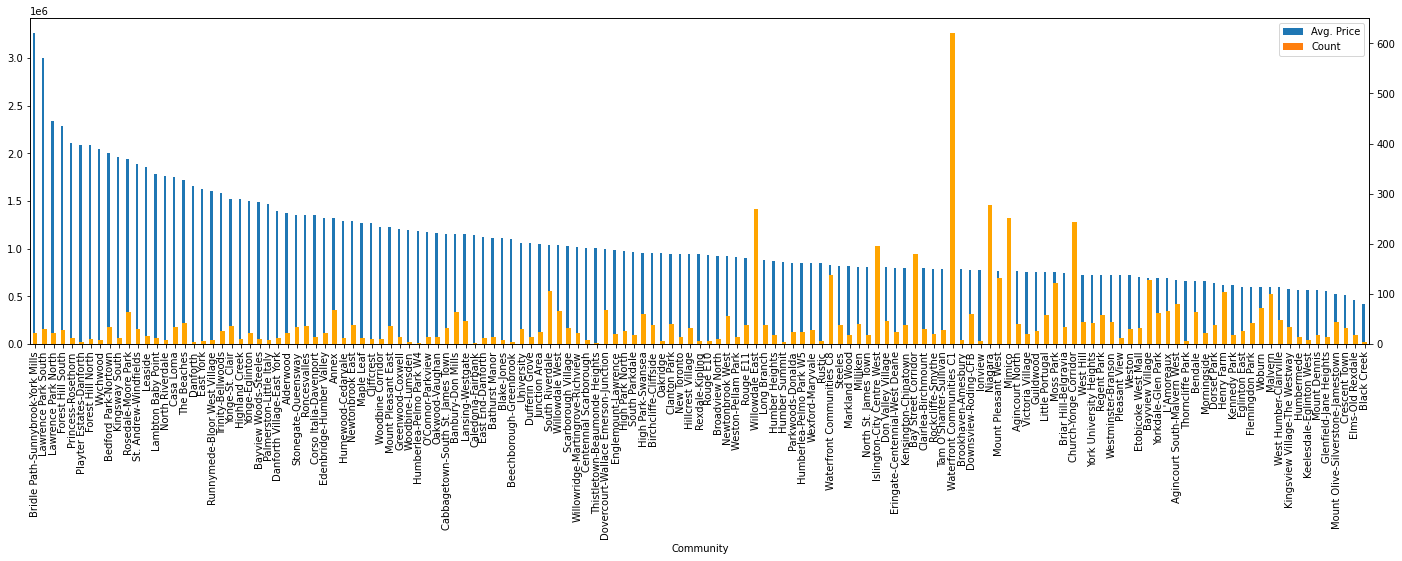

In [9]:
community_prices_sorted.plot.bar(figsize=(24,6))
community_prices_sorted['Count'].plot(kind='bar', color='Orange', secondary_y=True)

In [10]:
# Get average 'Sold_price' across districts
districts = df_train[['Sold_price','Municipality District']].groupby(['Municipality District'])

districts_prices = pd.concat([districts.mean(), districts.count()], axis=1)
districts_prices.columns = ['Avg. Price', 'Count']
districts_prices_sorted = districts_prices.sort_values(by=['Avg. Price'], ascending=False)
districts_prices_sorted

,Avg. Price,Count
Municipality District,,
C12,2467140,50
C04,2148237,113
C09,1938290,63
C03,1696362,75
E02,1529803,63
C02,1506860,143
W07,1356736,34
W02,1109768,136
E01,1101540,133


<AxesSubplot:>

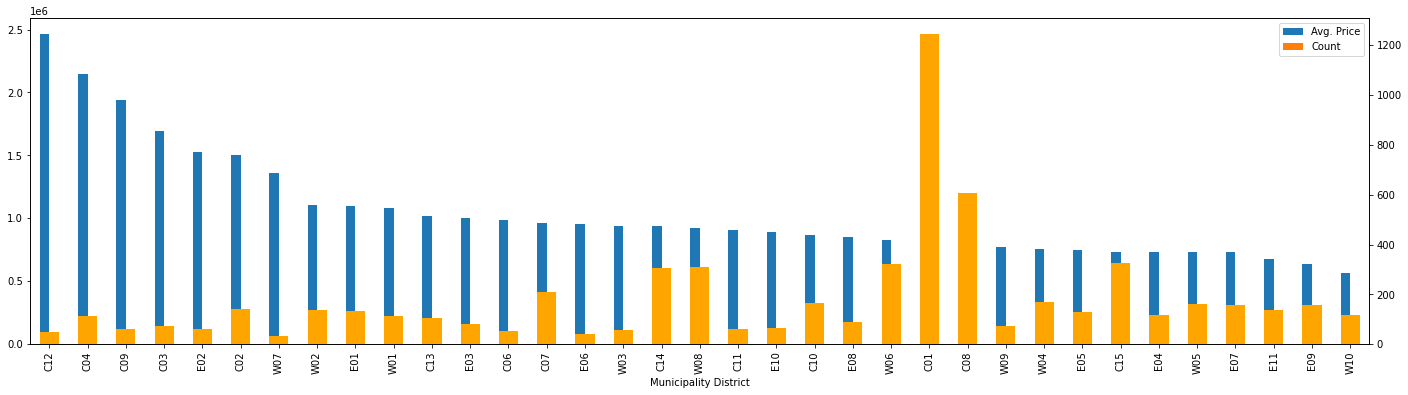

In [11]:
districts_prices_sorted.plot.bar(figsize=(24,6))
districts_prices_sorted['Count'].plot(kind='bar', color='Orange', secondary_y=True)

In [12]:
# Communities with <5 data points
community_prices_sorted[community_prices_sorted['Count'] <= 15].sort_values(by=['Count'], ascending=True).to_csv("./output")

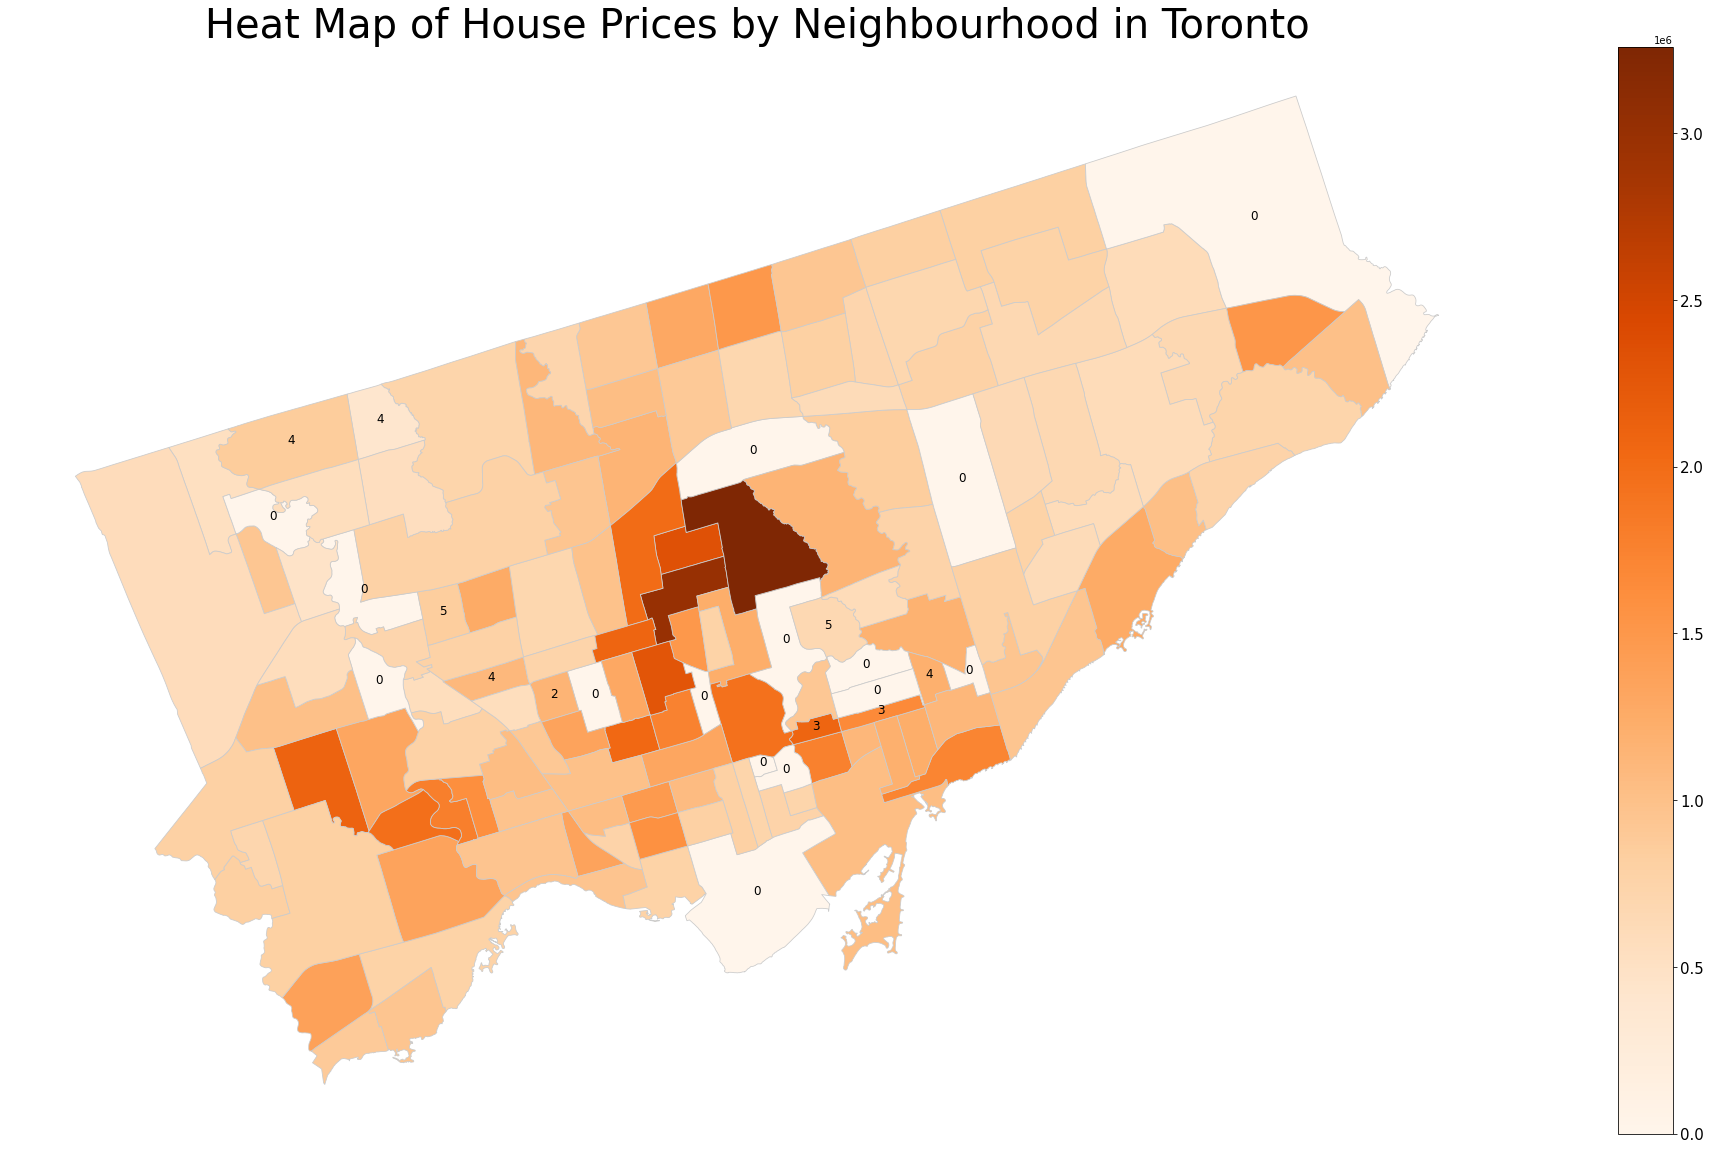

In [13]:
#get map
neighbourhood_map = gpd.read_file('../input/folder/forAnalysis/Neighbourhoods/Neighbourhoods.shp')
neighbourhood_map['neighbourhood'] = neighbourhood_map['FIELD_7'].str.replace(' \(.+\)', '').str.lower()

#merge data
community_prices['Neighbourhood'] = community_prices.index.str.lower()
community_prices.reset_index(drop=True, inplace=True)

merged = neighbourhood_map.set_index('neighbourhood').join(community_prices.set_index('Neighbourhood'))
merged = merged.reset_index()
merged = merged.fillna(0)

#create heat map
fig, ax = plt.subplots(1, figsize=(40, 20))
ax.axis('off')
ax.set_title('Heat Map of House Prices by Neighbourhood in Toronto', fontdict={'fontsize': '40', 'fontweight' : '3'})

#create colorbar as a legend
color = 'Oranges'
vmin, vmax = 0, merged['Avg. Price'].max()
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=15)

# plot map - annotated neighbourhoods with >5 count
merged.plot('Avg. Price', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(40, 20))
for idx, row in merged.iterrows():
    if(row['Count'] <= 5):
        plt.annotate(s=int(row['Count']), xy=(row['FIELD_11'], row['FIELD_12']),
                 horizontalalignment='center', fontsize='large', color='black', wrap=True)
plt.show()

In [14]:
# List of 0 count neighbourhoods
merged[merged['Count']<16][['neighbourhood','Avg. Price', 'Count']].sort_values(by=['Count'], ascending=True).to_csv('./output.csv')

### Correlation matrix

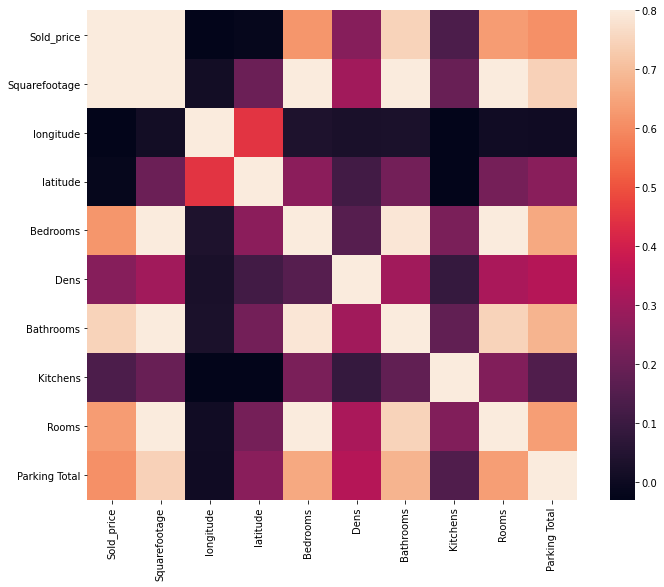

In [15]:
#correlation matrix
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## Begin Data Engineering

### Type

In [16]:
# Get average 'Sold_price' across communities (neighbourhoods)
types = df_train[['Sold_price','Type']].groupby(['Type'])

type_prices = pd.concat([types.mean(), types.count()], axis=1)
type_prices.columns = ['Avg. Price', 'Count']
type_prices.sort_values(by=['Avg. Price'], ascending=False)

,Avg. Price,Count
Type,,
Detached,2060755,749
Semi-Detached,1411993,227
Townhouse,1226299,157
Condo Townhouse,832240,675
Condo Apartment,702938,4365
Co-op / Co-Ownership Apartment,633823,35


#### Use one hot encoding for Type data

In [17]:
oneHot = OneHotEncoder(handle_unknown='ignore')
ce_ohe = ce.OneHotEncoder(cols = ['Type'], use_cat_names=True)
df_train= ce_ohe.fit_transform(df_train)
print(ce_ohe)
df_train.head()

OneHotEncoder(cols=['Type'], use_cat_names=True)


,Sold_price,Squarefootage,Type_Condo Apartment,Type_Co-op / Co-Ownership Apartment,Type_Condo Townhouse,Type_Townhouse,Type_Detached,Type_Semi-Detached,Style,Community,Municipality District,longitude,latitude,Bedrooms,Dens,Bathrooms,Kitchens,Rooms,Parking Total
0,205000,950,1,0,0,0,0,0,Apartment,Black Creek,W05,-80,44,2,0,1,1,5,1
1,230000,550,0,1,0,0,0,0,Apartment,West Hill,E10,-79,44,1,0,1,1,4,0
2,265000,950,1,0,0,0,0,0,2-Storey,West Hill,E10,-79,44,2,0,1,1,5,1
3,275000,250,1,0,0,0,0,0,Bachelor/Studio,Downsview-Roding-CFB,W05,-79,44,0,0,1,1,3,1
4,276500,1100,1,0,0,0,0,0,2-Storey,West Hill,E10,-79,44,2,0,1,1,5,1


### Style

In [18]:
# Get average 'Sold_price' across communities (neighbourhoods)
styles = df_train[['Sold_price','Style']].groupby(['Style'])

style_prices = pd.concat([styles.mean(), styles.count()], axis=1)
style_prices.columns = ['Avg. Price', 'Count']
style_prices.sort_values(by=['Avg. Price'], ascending=False)

,Avg. Price,Count
Style,,
2-Storey,1657684,1039
3-Storey,1383803,430
Bungalow,1210141,162
Loft,834971,192
Stacked Townhouse,728234,249
Apartment,696078,4023
Bachelor/Studio,473008,113


In [19]:
oneHot = OneHotEncoder(handle_unknown='ignore')
ce_ohe = ce.OneHotEncoder(cols = ['Style'], use_cat_names=True)
df_train= ce_ohe.fit_transform(df_train)
print(ce_ohe)
df_train.head()

OneHotEncoder(cols=['Style'], use_cat_names=True)


,Sold_price,Squarefootage,Type_Condo Apartment,Type_Co-op / Co-Ownership Apartment,Type_Condo Townhouse,Type_Townhouse,Type_Detached,Type_Semi-Detached,Style_Apartment,Style_2-Storey,...,Community,Municipality District,longitude,latitude,Bedrooms,Dens,Bathrooms,Kitchens,Rooms,Parking Total
0,205000,950,1,0,0,0,0,0,1,0,...,Black Creek,W05,-80,44,2,0,1,1,5,1
1,230000,550,0,1,0,0,0,0,1,0,...,West Hill,E10,-79,44,1,0,1,1,4,0
2,265000,950,1,0,0,0,0,0,0,1,...,West Hill,E10,-79,44,2,0,1,1,5,1
3,275000,250,1,0,0,0,0,0,0,0,...,Downsview-Roding-CFB,W05,-79,44,0,0,1,1,3,1
4,276500,1100,1,0,0,0,0,0,0,1,...,West Hill,E10,-79,44,2,0,1,1,5,1


### District and Community Encoding

In [20]:
# Bin districts
df_train['district_bin'] = df_train['Municipality District']
df_train['district_bin'][df_train['Municipality District'] == 'C12'] = 'district_bin_0'
df_train['district_bin'][df_train['Municipality District'] == 'C04'] = 'district_bin_1'
df_train['district_bin'][df_train['Municipality District'] == 'C09'] = 'district_bin_2'
df_train['district_bin'][df_train['Municipality District'] == 'C03'] = 'district_bin_3'
df_train['district_bin'][df_train['Municipality District'] == 'E02'] = 'district_bin_4'
df_train['district_bin'][df_train['Municipality District'] == 'C02'] = 'district_bin_4'
df_train['district_bin'][df_train['Municipality District'] == 'W07'] = 'district_bin_5'
df_train['district_bin'][df_train['Municipality District'] == 'W02'] = 'district_bin_6'
df_train['district_bin'][df_train['Municipality District'] == 'E01'] = 'district_bin_6'
df_train['district_bin'][df_train['Municipality District'] == 'W01'] = 'district_bin_6'
df_train['district_bin'][df_train['Municipality District'] == 'C13'] = 'district_bin_7'
df_train['district_bin'][df_train['Municipality District'] == 'E03'] = 'district_bin_7'
df_train['district_bin'][df_train['Municipality District'] == 'C06'] = 'district_bin_7'
df_train['district_bin'][df_train['Municipality District'] == 'C07'] = 'district_bin_8'
df_train['district_bin'][df_train['Municipality District'] == 'E06'] = 'district_bin_8'
df_train['district_bin'][df_train['Municipality District'] == 'W03'] = 'district_bin_8'
df_train['district_bin'][df_train['Municipality District'] == 'C14'] = 'district_bin_8'
df_train['district_bin'][df_train['Municipality District'] == 'W08'] = 'district_bin_8'
df_train['district_bin'][df_train['Municipality District'] == 'C11'] = 'district_bin_9'
df_train['district_bin'][df_train['Municipality District'] == 'E10'] = 'district_bin_9'
df_train['district_bin'][df_train['Municipality District'] == 'C10'] = 'district_bin_9'
df_train['district_bin'][df_train['Municipality District'] == 'E08'] = 'district_bin_10'
df_train['district_bin'][df_train['Municipality District'] == 'W06'] = 'district_bin_10'
df_train['district_bin'][df_train['Municipality District'] == 'C01'] = 'district_bin_10'
df_train['district_bin'][df_train['Municipality District'] == 'C08'] = 'district_bin_11'
df_train['district_bin'][df_train['Municipality District'] == 'W09'] = 'district_bin_11'
df_train['district_bin'][df_train['Municipality District'] == 'W04'] = 'district_bin_11'
df_train['district_bin'][df_train['Municipality District'] == 'E07'] = 'district_bin_12'
df_train['district_bin'][df_train['Municipality District'] == 'W05'] = 'district_bin_12'
df_train['district_bin'][df_train['Municipality District'] == 'E04'] = 'district_bin_12'
df_train['district_bin'][df_train['Municipality District'] == 'C15'] = 'district_bin_12'
df_train['district_bin'][df_train['Municipality District'] == 'E05'] = 'district_bin_12'
df_train['district_bin'][df_train['Municipality District'] == 'E11'] = 'district_bin_13'
df_train['district_bin'][df_train['Municipality District'] == 'E09'] = 'district_bin_13'
df_train['district_bin'][df_train['Municipality District'] == 'W10'] = 'district_bin_14'

# One-hot encode districts
oneHot = OneHotEncoder(handle_unknown='ignore')
ce_ohe = ce.OneHotEncoder(cols = ['district_bin'], use_cat_names=True)
df_train= ce_ohe.fit_transform(df_train)
df_train.head()

,Sold_price,Squarefootage,Type_Condo Apartment,Type_Co-op / Co-Ownership Apartment,Type_Condo Townhouse,Type_Townhouse,Type_Detached,Type_Semi-Detached,Style_Apartment,Style_2-Storey,...,district_bin_district_bin_13,district_bin_district_bin_14,district_bin_district_bin_7,district_bin_district_bin_1,district_bin_district_bin_8,district_bin_district_bin_4,district_bin_district_bin_6,district_bin_district_bin_5,district_bin_district_bin_2,district_bin_district_bin_0
0,205000,950,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,230000,550,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,265000,950,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,275000,250,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,276500,1100,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [21]:
def bin_range(start_of_range,start_of_next_range):
    return range(list(community_prices_sorted.index.values).index(start_of_range),list(community_prices_sorted.index.values).index(start_of_next_range))

# Set Community Bins
bins = [bin_range('Bridle Path-Sunnybrook-York Mills','Lawrence Park South')],\
        [bin_range('Lawrence Park South','Lawrence Park North')],\
        [bin_range('Lawrence Park North','Princess-Rosethorn')],\
        [bin_range('Princess-Rosethorn','Bedford Park-Nortown')],\
        [bin_range('Bedford Park-Nortown','St. Andrew-Windfields')],\
        [bin_range('St. Andrew-Windfields','Lambton Baby Point')],\
        [bin_range('Lambton Baby Point','Danforth')],\
        [bin_range('Danforth','Highland Creek')],\
        [bin_range('Highland Creek','Danforth Village-East York')],\
        [bin_range('Danforth Village-East York','Edenbridge-Humber Valley')],\
        [bin_range('Edenbridge-Humber Valley','Woodbine Corridor')],\
        [bin_range('Woodbine Corridor','Cabbagetown-South St. James Town')],\
        [bin_range('Cabbagetown-South St. James Town','University')],\
        [bin_range('University','Dovercourt-Wallace Emerson-Junction')],\
        [bin_range('Dovercourt-Wallace Emerson-Junction','Rouge E10')],\
        [bin_range('Rouge E10','Waterfront Communities C8')],\
        [bin_range('Waterfront Communities C8','Rockcliffe-Smythe')],\
        [bin_range('Rockcliffe-Smythe','Briar Hill-Belgravia')],\
        [bin_range('Briar Hill-Belgravia','Bayview Village')],\
        [bin_range('Bayview Village','Dorset Park')],\
        [bin_range('Dorset Park','Eglinton East')],\
        [bin_range('Eglinton East','Mount Olive-Silverstone-Jamestown')],\
        [bin_range('Mount Olive-Silverstone-Jamestown','Elms-Old Rexdale')],\
        [bin_range('Elms-Old Rexdale','Black Creek')]

df_train['community_bin'] = np.nan

for idx,item in enumerate(bins):
    bin_name = 'community_bin_' + str(idx)
    df_train['community_bin'][df_train['Community'].isin(community_prices_sorted.index.values[item])] = bin_name
    last_bin_name = bin_name

# Set end of last range 
df_train['community_bin'][df_train['Community'] == 'Black Creek'] = last_bin_name
    
# One-hot encode Community Bins
oneHot = OneHotEncoder(handle_unknown='ignore')
ce_ohe = ce.OneHotEncoder(cols = ['community_bin'], use_cat_names=True)
df_train= ce_ohe.fit_transform(df_train)
df_train.head()

,Sold_price,Squarefootage,Type_Condo Apartment,Type_Co-op / Co-Ownership Apartment,Type_Condo Townhouse,Type_Townhouse,Type_Detached,Type_Semi-Detached,Style_Apartment,Style_2-Storey,...,community_bin_community_bin_20,community_bin_community_bin_12,community_bin_community_bin_6,community_bin_community_bin_3,community_bin_community_bin_11,community_bin_community_bin_5,community_bin_community_bin_8,community_bin_community_bin_7,community_bin_community_bin_1,community_bin_community_bin_0
0,205000,950,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,230000,550,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,265000,950,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,275000,250,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,276500,1100,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### Combine Bedrooms and Den Columns

In [22]:
beds = df_train[['Bedrooms','Dens']]
multiplier = 0.48

beds_prices = pd.concat([beds.Bedrooms, beds.Dens, beds.Bedrooms.astype(float) + multiplier * beds.Dens.astype(float)], axis=1)
pd.options.display.float_format = '{:,.2f}'.format
beds_prices.columns = ['Bedrooms', 'Dens', 'Combined']

beds_prices

,Bedrooms,Dens,Combined
0,2,0,2.00
1,1,0,1.00
2,2,0,2.00
3,0,0,0.00
4,2,0,2.00
...,...,...,...
6203,4,1,4.48
6204,4,2,4.96
6205,5,1,5.48
6206,4,1,4.48


#### Compare Combined Correlation

Correlation:
Bedrooms -  0.6210575646477735 
Dens     -  0.2514301015976362 
Combined -  0.6404507775921144


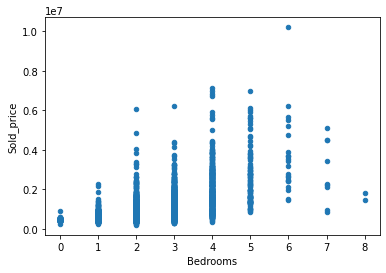

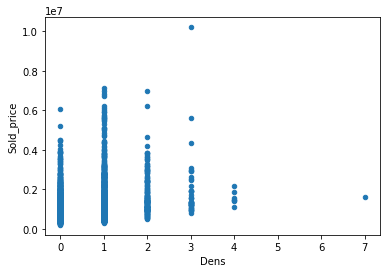

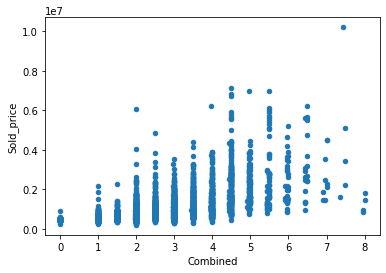

In [23]:
#Combined vs. Bedrooms vs. Dens 
bedrooms = pd.concat([df_train['Sold_price'], beds_prices['Bedrooms']], axis=1)
bedrooms.plot.scatter(x='Bedrooms', y='Sold_price')

dens = pd.concat([df_train['Sold_price'], beds_prices['Dens']], axis=1)
dens.plot.scatter(x='Dens', y='Sold_price')

combined = pd.concat([df_train['Sold_price'], beds_prices['Combined']], axis=1)
combined.plot.scatter(x='Combined', y='Sold_price')

print('Correlation:\nBedrooms - ', df_train['Sold_price'].corr(beds_prices['Bedrooms']),
                  '\nDens     - ', df_train['Sold_price'].corr(beds_prices['Dens']),
                  '\nCombined - ', df_train['Sold_price'].corr(beds_prices['Combined']))


#### Optimize Dens Multiplier

In [24]:
# Correlation score of 'Combined' as a function of the multiplier
def combined_correlation(multiplier):
    return df_train['Sold_price'].corr(beds.Bedrooms + beds.Dens * multiplier)

# Create table with possible multiplier values on each row
optimize = pd.DataFrame(columns=['multiplier','combined_correlation'])
optimize['multiplier'] = np.linspace(0,1,1000) # 1000 values b/w 0 and 1

# Calculate Correlation score for each row
for idx, row in optimize.iterrows():   
    optimize['combined_correlation'][idx] = combined_correlation(optimize['multiplier'][idx])

# Get multiplier for maximum Correlation score
print('multiplier: ', optimize.loc[optimize['combined_correlation']==optimize['combined_correlation'].max(), 'multiplier'].iloc[0])


multiplier:  0.4744744744744745


### Bathrooms, Kitchens, Rooms, Parking Total Correlations

Correlation:
Bathrooms -  0.7456495798423914 
Kitchens  -  0.13557569823899385 
Rooms     -  0.2514301015976362 
Parking   -  0.6102655072304203


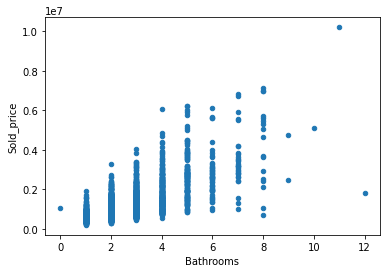

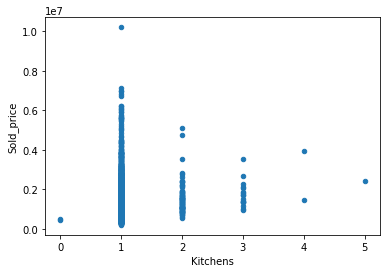

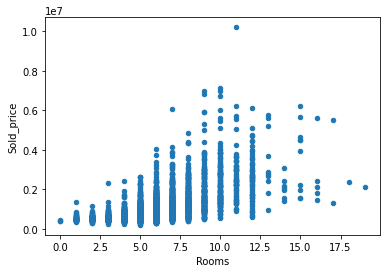

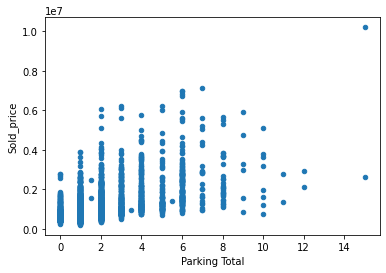

In [25]:
bathrooms = pd.concat([df_train['Sold_price'], df_train['Bathrooms']], axis=1)
bathrooms.plot.scatter(x='Bathrooms', y='Sold_price')

kitchen = pd.concat([df_train['Sold_price'], df_train['Kitchens']], axis=1)
kitchen.plot.scatter(x='Kitchens', y='Sold_price')

rooms = pd.concat([df_train['Sold_price'], df_train['Rooms']], axis=1)
rooms.plot.scatter(x='Rooms', y='Sold_price')

parking = pd.concat([df_train['Sold_price'], df_train['Parking Total']], axis=1)
parking.plot.scatter(x='Parking Total', y='Sold_price')

print('Correlation:\nBathrooms - ', df_train['Sold_price'].corr(df_train['Bathrooms']),
                  '\nKitchens  - ', df_train['Sold_price'].corr(df_train['Kitchens']),
                  '\nRooms     - ', df_train['Sold_price'].corr(df_train['Dens']),
                  '\nParking   - ', df_train['Sold_price'].corr(df_train['Parking Total']))

### Transform Skewed Data

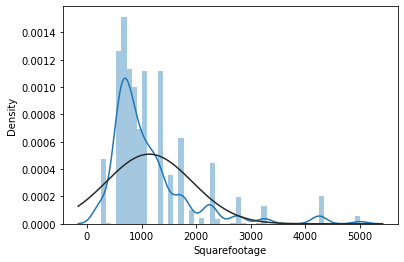

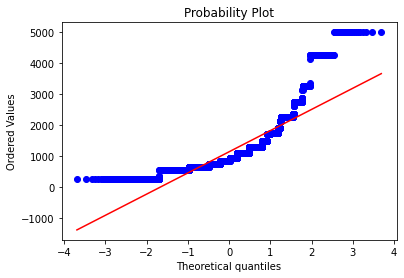

In [26]:
# histogram and normal probability plot
sns.distplot(df_train['Squarefootage'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['Squarefootage'], plot=plt)

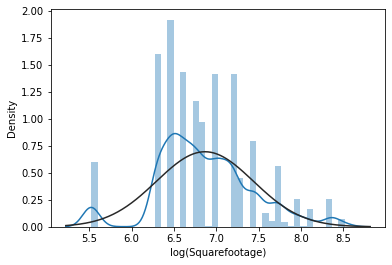

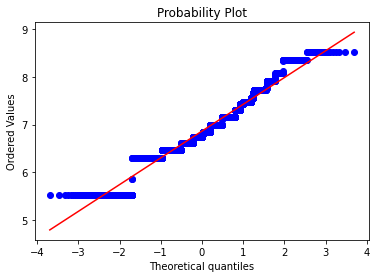

In [27]:
# log squarefootage
df_train['log(Squarefootage)'] = np.log(df_train['Squarefootage'])

sns.distplot(df_train['log(Squarefootage)'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['log(Squarefootage)'], plot=plt)

### Drop latitude, longitude, kitchens, squarefootage, rooms rows

In [28]:
df_train = df_train.drop(['longitude', 'latitude', 'Rooms', 'Kitchens', 'Squarefootage', 'Community', 'Municipality District'], axis=1)
df_train.head()

,Sold_price,Type_Condo Apartment,Type_Co-op / Co-Ownership Apartment,Type_Condo Townhouse,Type_Townhouse,Type_Detached,Type_Semi-Detached,Style_Apartment,Style_2-Storey,Style_Bachelor/Studio,...,community_bin_community_bin_12,community_bin_community_bin_6,community_bin_community_bin_3,community_bin_community_bin_11,community_bin_community_bin_5,community_bin_community_bin_8,community_bin_community_bin_7,community_bin_community_bin_1,community_bin_community_bin_0,log(Squarefootage)
0,205000,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6.86
1,230000,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,6.31
2,265000,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,6.86
3,275000,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.52
4,276500,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,7.00


### Drop/Transform Outliers

In [29]:
# Drop 7 dens
df_train = df_train.drop(df_train[df_train['Dens']==7].index.values)

# Drop Bathrooms 9+
df_train = df_train.drop(df_train[df_train['Bathrooms']>=9].index.values)
df_train = df_train.drop(df_train[df_train['Bathrooms']==0].index.values)

# Drop Parking 9+
df_train = df_train.drop(df_train[df_train['Parking Total']>=9].index.values)

# Round down .5 Parking Total
df_train["Parking Total"].replace({"1.5": "1", "3.5": "3", "5.5": "5"}, inplace=True)

### Normalize values to help NN train

In [30]:
df_train[:1].values

array([[2.05000000e+05, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 2.00000000e+00, 0.00000000e+00,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [31]:
# Scale Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(df_train)

scaled_train = pd.DataFrame(data=scaled_train, columns=df_train.columns)

In [32]:
scaled_train[:1].values

array([[0.       , 1.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 1.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.25     , 0.       , 0.       , 0.125    ,
        1.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 1.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
        0.       , 0.       , 0.       , 0.4456343]])

In [33]:
print("Columns")
print(scaled_train.columns)
# Get scaled values
# Print out the adjustment that the scaler applied to the total_earnings column of data
print("Note: sold_price values were scaled by multiplying by {:.10f} and adding {:.6f}".format(scaler.scale_[0], scaler.min_[0]))
multiplied_by = scaler.scale_[0]
added = scaler.min_[0]
print("Multiplied by")
print(scaler.scale_)
print("Added")
print(scaler.min_)

Columns
Index(['Sold_price', 'Type_Condo Apartment',
       'Type_Co-op / Co-Ownership Apartment', 'Type_Condo Townhouse',
       'Type_Townhouse', 'Type_Detached', 'Type_Semi-Detached',
       'Style_Apartment', 'Style_2-Storey', 'Style_Bachelor/Studio',
       'Style_Stacked Townhouse', 'Style_3-Storey', 'Style_Loft',
       'Style_Bungalow', 'Bedrooms', 'Dens', 'Bathrooms', 'Parking Total',
       'district_bin_district_bin_12', 'district_bin_district_bin_9',
       'district_bin_district_bin_10', 'district_bin_district_bin_3',
       'district_bin_district_bin_11', 'district_bin_district_bin_13',
       'district_bin_district_bin_14', 'district_bin_district_bin_7',
       'district_bin_district_bin_1', 'district_bin_district_bin_8',
       'district_bin_district_bin_4', 'district_bin_district_bin_6',
       'district_bin_district_bin_5', 'district_bin_district_bin_2',
       'district_bin_district_bin_0', 'community_bin_community_bin_23',
       'community_bin_community_bin_18', 'c

### Separate Dataset into Train (70%), Validation (20%),Test (10%)

5566
619
6185


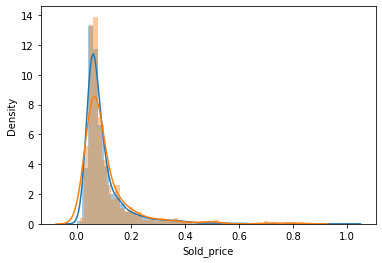

In [34]:
# Split Data
train, test = np.split(scaled_train.sample(frac=1, random_state=42),\
                        [int(.9*len(scaled_train))])

sns.distplot(train['Sold_price'])
sns.distplot(test['Sold_price'])

print(len(train))
print(len(test))
print(len(test)+len(train))

### Setup input, label data

In [35]:
y_train_data = train.values[:,0]
y_test_data = test.values[:,0]
x_train_data = train.values[:,1:]
x_test_data = test.values[:,1:]

In [36]:
# Get input shape
len(x_train_data[0])

57

## Finished Data Engineering
## Begin Neural Network

In [37]:
# Imports
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout

In [38]:
# Build model
model = Sequential()

model.add(Dense(50, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')

In [39]:
# Train the model
hist = model.fit(
    x_train_data,
    y_train_data,
    epochs=50,
    shuffle=True,
    verbose=2,
    validation_data=(x_test_data, y_test_data)
)

Epoch 1/50
174/174 - 1s - loss: 0.0043 - val_loss: 0.0026
Epoch 2/50
174/174 - 0s - loss: 0.0022 - val_loss: 0.0022
Epoch 3/50
174/174 - 0s - loss: 0.0016 - val_loss: 0.0019
Epoch 4/50
174/174 - 0s - loss: 0.0015 - val_loss: 0.0019
Epoch 5/50
174/174 - 0s - loss: 0.0013 - val_loss: 0.0020
Epoch 6/50
174/174 - 0s - loss: 0.0011 - val_loss: 0.0021
Epoch 7/50
174/174 - 0s - loss: 0.0012 - val_loss: 0.0019
Epoch 8/50
174/174 - 0s - loss: 0.0010 - val_loss: 0.0019
Epoch 9/50
174/174 - 0s - loss: 0.0010 - val_loss: 0.0018
Epoch 10/50
174/174 - 0s - loss: 9.4650e-04 - val_loss: 0.0018
Epoch 11/50
174/174 - 0s - loss: 9.2608e-04 - val_loss: 0.0017
Epoch 12/50
174/174 - 0s - loss: 8.8816e-04 - val_loss: 0.0019
Epoch 13/50
174/174 - 0s - loss: 9.1702e-04 - val_loss: 0.0017
Epoch 14/50
174/174 - 0s - loss: 8.0653e-04 - val_loss: 0.0019
Epoch 15/50
174/174 - 0s - loss: 8.2890e-04 - val_loss: 0.0018
Epoch 16/50
174/174 - 0s - loss: 8.3621e-04 - val_loss: 0.0018
Epoch 17/50
174/174 - 0s - loss: 7.69

### Visualize Results

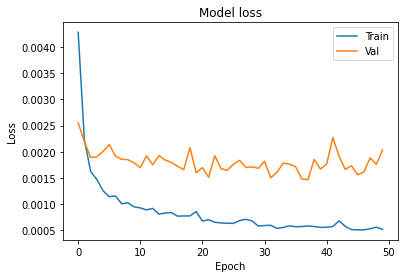

In [40]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [41]:
model.save('model')

In [42]:
loaded_model = keras.models.load_model('model')

In [43]:
x_test_data[:1]

array([[0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.5       , 0.25      ,
        0.42857143, 0.5       , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.73352575]])

In [44]:
# Inference
prediction = loaded_model.predict(x_test_data[:1])
y_0 = prediction[0][0]
print('Prediction with scaling - {}',format(y_0))
y_0 -= added
y_0 /= multiplied_by
print("Housing Price Prediction  - ${}".format(y_0))
actual = y_test_data[:1]
print('Actual with scaling - {}',format(actual))
actual -= added
actual /= multiplied_by
print("Housing Price Prediction  - ${}".format(actual))

Prediction with scaling - {} 0.1741335093975067
Housing Price Prediction  - $1414357.2227656841
Actual with scaling - {} [0.15478762]
Housing Price Prediction  - $[1280000.]
